In [1]:
%%time
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --no-index --find-links=file:///kaggle/input/torch-geometric

Looking in links: file:///kaggle/input/torch-geometric
Processing /kaggle/input/torch-geometric/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_cluster-1.6.0-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_spline_conv-1.2.1-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_geometric-2.2.0-py3-none-any.whl
CPU times: user 164 ms, sys: 19.6 ms, total: 184 ms
Wall time: 11.7 s


In [2]:
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from sklearn.metrics import r2_score
from torch.nn.functional import one_hot
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from scipy.stats import pearsonr

from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import mpn_model

In [3]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def load_dataset(data_path, n_graphs=400):
    dataset=[]
    for i in range(0, n_graphs):
        graph = torch.load(data_path+f"/graph{i}.pt")
        x_oh = one_hot(graph.x.flatten().type(torch.LongTensor), num_classes=2).type(torch.cuda.FloatTensor)
        graph.x = x_oh
        dataset.append(graph)
    return dataset

In [6]:
dataset = load_dataset("/kaggle/input/bapst-data-static-structure-in-glasses/graphs", n_graphs=400)

In [7]:
dataset[0]

Data(x=[4096, 2], edge_index=[2, 167710], edge_attr=[167710, 3], y=[4096, 1], pos=[4096, 3], e_pot=0, pair_pot=0, edge_targets=[167710, 1], delta_r_cage=[4096, 1])

In [8]:
full_y = np.concatenate([graph.y for graph in dataset], axis=0)

(array([3.09900e+04, 1.65660e+05, 2.59488e+05, 2.90865e+05, 2.65617e+05,
        2.03984e+05, 1.35423e+05, 8.11040e+04, 5.04540e+04, 3.53460e+04,
        2.81230e+04, 2.36130e+04, 1.97940e+04, 1.57240e+04, 1.17650e+04,
        8.18600e+03, 5.31700e+03, 3.16200e+03, 1.89200e+03, 9.60000e+02,
        5.18000e+02, 2.19000e+02, 1.20000e+02, 5.20000e+01, 1.20000e+01,
        4.00000e+00, 5.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([0.09996451, 0.20179093, 0.30361733, 0.40544376, 0.50727016,
        0.6090966 , 0.710923  , 0.81274945, 0.9145758 , 1.0164022 ,
        1.1182287 , 1.2200551 , 1.3218815 , 1.423708  , 1.5255344 ,
        1.6273608 , 1.7291871 , 1.8310136 , 1.93284   , 2.0346665 ,
        2.136493  , 2.2383192 , 2.3401456 , 2.441972  , 2.5437984 ,
        2.6456249 , 2.7474513 , 2.8492777 , 2.9511042 , 3.0529306 ,
        3.154757  ], dtype=float32),
 <BarContainer object of 30 artists>)

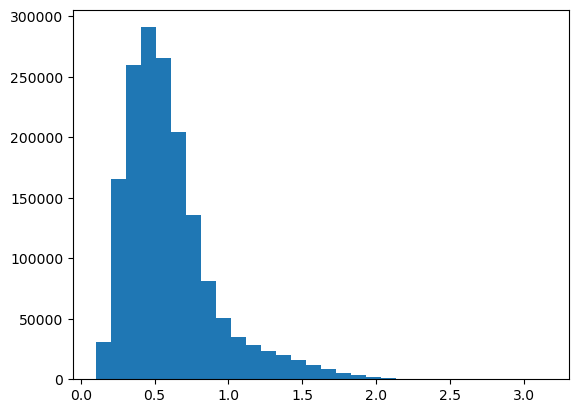

In [9]:
plt.hist(full_y, bins=30)

In [10]:
full_y.mean(), full_y.std()

(0.59985614, 0.3091052)

In [11]:
train_dataset, test_dataset = train_test_split(dataset, test_size=40, random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=40, random_state=43)

In [12]:
train_y = np.concatenate([graph.y for graph in train_dataset], axis=0)

In [13]:
y_mean = train_y.mean()
y_std = train_y.std()

In [14]:
y_mean, y_std

(0.5988441, 0.30760044)

In [15]:
print(len(train_dataset), 'training graphs')
print(len(val_dataset), 'validation graphs')
print(len(test_dataset), 'test graphs')

320 training graphs
40 validation graphs
40 test graphs


In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [17]:
def train(model, train_loader, optimizer, loss):
    model.train()
    loss_acc = 0
    total_a_nodes = 0

    total_preds = []
    labels = []

    for graph_batch in train_loader:
        graph_batch = graph_batch.to(device)
        optimizer.zero_grad()
        preds = model(graph_batch.x, graph_batch.edge_attr, graph_batch.edge_index)
        
        vector_loss = loss(preds.squeeze(), (graph_batch.y.squeeze() - y_mean)/y_std)
        type_a_mask = graph_batch.x[:,0]
        loss_val = torch.dot(vector_loss, type_a_mask) 
        
        loss_acc += loss_val.item()
        total_a_nodes += graph_batch.x[:, 0].sum().item()
        
        loss_val.backward()
        optimizer.step()

        total_preds.extend(y_std*preds[graph_batch.x[:, 0]==1.].cpu().detach().numpy().flatten() + y_mean)
        labels.extend(graph_batch.y[graph_batch.x[:, 0]==1.].cpu().detach().numpy().flatten())
        
    loss_acc /= total_a_nodes
#     print(labels[:20], total_preds[:20])
    correlation = pearsonr(labels, total_preds)[0]
    r2 = r2_score(labels, total_preds)

    return loss_acc, correlation, r2

In [18]:
def validate(model, valid_loader, loss):
    model.eval()
    loss_acc = 0
    total_a_nodes = 0
    total_preds = []
    labels = []
    
    with torch.no_grad():
        for graph_batch in valid_loader:
            graph_batch = graph_batch.to(device)
            preds = model(graph_batch.x, graph_batch.edge_attr, graph_batch.edge_index)
            
            vector_loss = loss(preds.squeeze(), (graph_batch.y.squeeze() - y_mean)/y_std)
            type_a_mask = graph_batch.x[:,0]
            loss_val = torch.dot(vector_loss, type_a_mask)
            loss_acc += loss_val.item()
            
            total_a_nodes += graph_batch.x[:, 0].sum().item()
            total_preds.extend(y_std*preds[graph_batch.x[:, 0]==1.].cpu().detach().numpy().flatten() + y_mean)
            labels.extend(graph_batch.y[graph_batch.x[:, 0]==1.].cpu().detach().numpy().flatten())

    loss_acc /= total_a_nodes
    if len(set(total_preds)) == 1:
        raise Exception('Constant prediction')
    correlation = pearsonr(labels, total_preds)[0]            
    r2 = r2_score(labels, total_preds)

    return loss_acc, correlation, r2

In [19]:
model = mpn_model.PaperGNN(7).to(device)


In [21]:
seed = 42
seed_everything(seed)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = nn.MSELoss(reduction='none')
scheduler = StepLR(optimizer, step_size=10, gamma=0.3)
train_loss = []
val_loss = []

train_r2 = []
val_r2 = []

train_correlation = []
val_correlation = []

for epoch in range(400):
    print('EPOCH:', epoch+1)
    print('Training...')
    loss_value, correlation, r2_value = train(model, train_dataloader, optimizer, loss)
    train_loss.append(loss_value)
    train_correlation.append(correlation)
    train_r2.append(r2_value)

    print('Validating..')
    loss_value, correlation, r2_value = validate(model, val_dataloader, loss)
    val_loss.append(loss_value)
    val_correlation.append(correlation)
    val_r2.append(r2_value)

    scheduler.step(loss_value)


    print('Training Loss:', train_loss[-1])
    print('Training correlation:', train_correlation[-1])
    print('Training r2:', train_r2[-1])

    print('Validation Loss:', val_loss[-1])
    print('Validation correlation:', val_correlation[-1])
    print('Validation r2:', val_r2[-1])

EPOCH: 1
Training...
Validating..
Training Loss: 0.23627539836381825
Training correlation: 0.5827803998480864
Training r2: 0.33962634331806396
Validation Loss: 0.2659303638969284
Validation correlation: 0.5787953595506333
Validation r2: 0.3331690078478565
EPOCH: 2
Training...
Validating..
Training Loss: 0.2360328229637018
Training correlation: 0.5833879694208879
Training r2: 0.34030432193045446
Validation Loss: 0.26780317467743936
Validation correlation: 0.5787571453795902
Validation r2: 0.3284728741040781
EPOCH: 3
Training...
Validating..
Training Loss: 0.23583329997849894
Training correlation: 0.5838410233039903
Training r2: 0.34086197635383464
Validation Loss: 0.2682732999706763
Validation correlation: 0.5788260019538558
Validation r2: 0.32729400906037887
EPOCH: 4
Training...
Validating..
Training Loss: 0.23578586176760793
Training correlation: 0.5839857992294667
Training r2: 0.34099456000818107
Validation Loss: 0.26592357124465976
Validation correlation: 0.5789568018202742
Validati

In [22]:
torch.save(model.state_dict(), 'model.pt')

In [23]:
results_dict = {
    'train_loss': train_loss,
    'validation_loss': val_loss,
    'train_correlation': train_correlation,
    'validation_correlation': val_correlation,
    'train_r2': train_r2,
    'validation_r2': val_r2
}

In [24]:
with open('results.json', 'w') as f:
    json.dump(results_dict, f)